In [1]:
# Importing necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import time
import torchvision
import os
import copy
import ssl
import pandas as pd
from torchvision import datasets, models, transforms
from numpy import savetxt
import shutil
from sklearn.model_selection import train_test_split


from torchvision.models import AlexNet_Weights

import seaborn as sns
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [2]:
# Define the input path and separate output paths for images and labels
input_path = "/kaggle/input/wadaba"
output_images_path = "/kaggle/working/wadaba/images"
output_labels_path = "/kaggle/working/wadaba/labels"

# Create output folders for images and labels if they don't exist
os.makedirs(output_images_path, exist_ok=True)
os.makedirs(output_labels_path, exist_ok=True)

# Iterate through each folder in the input path
for folder_name in os.listdir(input_path):
    folder_path = os.path.join(input_path, folder_name)

    # Check if it's a folder
    if os.path.isdir(folder_path):
        # Create corresponding folders in images and labels output directories
        image_dest_folder = os.path.join(output_images_path, folder_name)
        label_dest_folder = os.path.join(output_labels_path, folder_name)
        os.makedirs(image_dest_folder, exist_ok=True)
        os.makedirs(label_dest_folder, exist_ok=True)

        # Separate images and labels
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            # If the file is an image, copy it to the images folder
            if file_name.endswith('.jpg') and os.path.isfile(file_path):
                shutil.copy(file_path, image_dest_folder)

            # If the file is a label, copy it to the labels folder
            elif file_name.endswith('.txt') and os.path.isfile(file_path):
                shutil.copy(file_path, label_dest_folder)

print("Images and labels have been separated into different directories.")

Images and labels have been separated into different directories.


Image counts by folder:
PS: 520
PE_HD: 600
Other: 40
PET: 2200
PP: 640


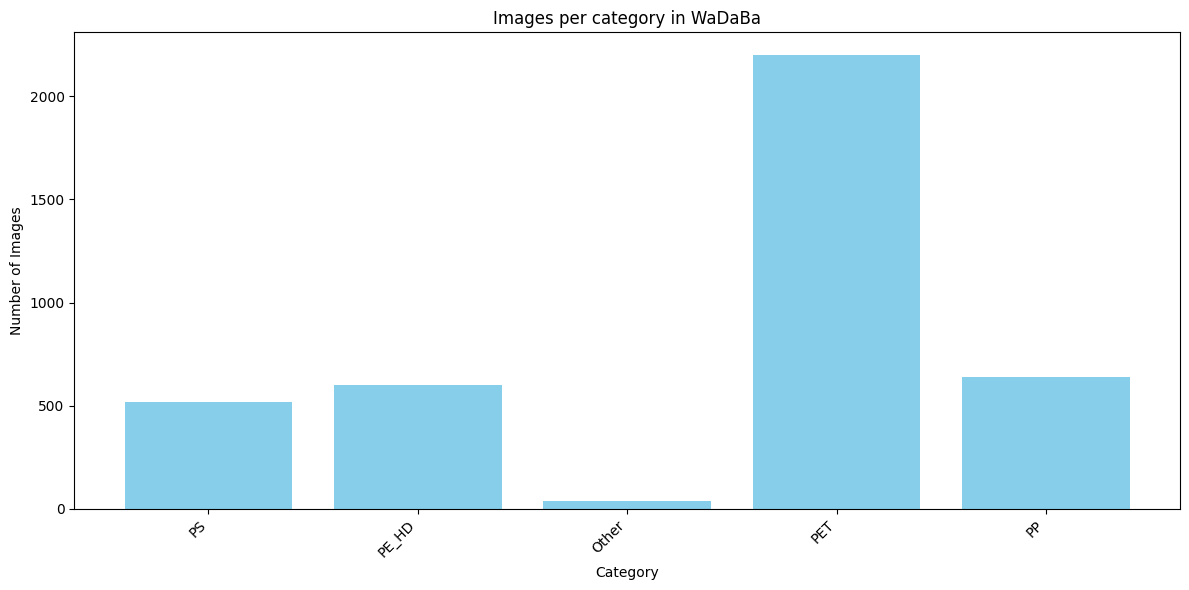

In [3]:
# Define the parent directory containing the inner folders
parent_dir = "/kaggle/working/wadaba/images"  # Directory where folders are located

# Initialize dictionaries to hold the folder names and their respective image counts
folder_names = []
image_counts = []

# Iterate through each folder in the parent directory
for folder_name in os.listdir(parent_dir):
    folder_path = os.path.join(parent_dir, folder_name)
    if os.path.isdir(folder_path):  # Ensure it's a directory
        # Count the number of .jpg files in the folder
        count = 0
        for filename in os.listdir(folder_path):
            if filename.endswith(".jpg"):  # Ensure it's a .jpg file
                count += 1
        
        # Store the folder name and count
        folder_names.append(folder_name)
        image_counts.append(count)

# Print the counts for debugging
print("Image counts by folder:")
for folder_name, count in zip(folder_names, image_counts):
    print(f"{folder_name}: {count}")

# Plot the data
plt.figure(figsize=(12, 6))
plt.bar(folder_names, image_counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Images per category in WaDaBa')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot to a file
plt.savefig("image_counts_in_wadaba.png")

# Show the plot
plt.show()

In [4]:
image_counts = {
    'PS': 520,
    'PET': 2200,
    'PP': 640,
    'Other': 40,
    'PE_HD': 600
}

In [5]:
# Define the data directories
parent_dir = "/kaggle/working/wadaba/images"  # Directory where image folders are located
label_dir = "/kaggle/working/wadaba/labels"  # Directory where label folders are located
train_dir = "/kaggle/working/wadaba/train"
val_dir = "/kaggle/working/wadaba/val"

# Create directories for training and validation if they don't exist
for folder in ['PS', 'PET', 'PP', 'Other', 'PE_HD']:
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, folder), exist_ok=True)

# Function to split dataset
def split_dataset(folder, image_list, split_ratio=0.8):
    train_size = int(len(image_list) * split_ratio)
    train_files, val_files = train_test_split(image_list, train_size=train_size, shuffle=True)
    return train_files, val_files

# Iterate through each class folder and split images and their corresponding labels
for folder in ['PS', 'PET', 'PP', 'Other', 'PE_HD']:
    folder_path = os.path.join(parent_dir, folder)
    label_folder_path = os.path.join(label_dir, folder)
    
    # Collect all .jpg files
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    # Split into train and validation sets
    train_files, val_files = split_dataset(folder, all_files)

    # Move training files (images and corresponding labels)
    for file_name in train_files:
        # Copy image
        shutil.copy(os.path.join(folder_path, file_name), os.path.join(train_dir, folder, file_name))
        # Copy corresponding label (if exists)
        label_file_name = file_name.replace('.jpg', '.txt')
        if os.path.exists(os.path.join(label_folder_path, label_file_name)):
            shutil.copy(os.path.join(label_folder_path, label_file_name), os.path.join(train_dir, folder, label_file_name))

    # Move validation files (images and corresponding labels)
    for file_name in val_files:
        # Copy image
        shutil.copy(os.path.join(folder_path, file_name), os.path.join(val_dir, folder, file_name))
        # Copy corresponding label (if exists)
        label_file_name = file_name.replace('.jpg', '.txt')
        if os.path.exists(os.path.join(label_folder_path, label_file_name)):
            shutil.copy(os.path.join(label_folder_path, label_file_name), os.path.join(val_dir, folder, label_file_name))

print("Dataset splitting complete.")


Dataset splitting complete.


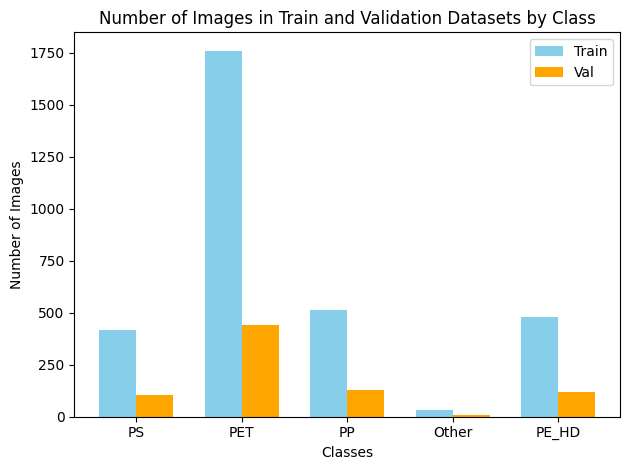

In [6]:
# Initialize counters
train_counts = []
val_counts = []

# Define the classes
classes = ['PS', 'PET', 'PP', 'Other', 'PE_HD']

# Count images in each class folder for train and val directories
for cls in classes:
    train_class_path = os.path.join(train_dir, cls)
    val_class_path = os.path.join(val_dir, cls)
    
    # Count only .jpg files in each class directory
    train_counts.append(len([f for f in os.listdir(train_class_path) if f.endswith('.jpg')]))
    val_counts.append(len([f for f in os.listdir(val_class_path) if f.endswith('.jpg')]))

# Plotting
x = range(len(classes))
width = 0.35  # Width of bars

fig, ax = plt.subplots()

# Bar plots for train and validation datasets
bar1 = ax.bar(x, train_counts, width, label='Train', color='skyblue')
bar2 = ax.bar([i + width for i in x], val_counts, width, label='Val', color='orange')

# Labeling
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images in Train and Validation Datasets by Class')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(classes)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [7]:

# Disable interactive mode for matplotlib (if you don't want live updates)
plt.ioff()  # Use this to turn off interactivity

# If facing SSL errors while downloading, use this
ssl._create_default_https_context = ssl._create_unverified_context

# Lists to store training and validation accuracy and loss for plotting
accuracy_train_plot = []
loss_train_plot = []
accuracy_val_plot = []
loss_val_plot = []

# Define transformations for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),   # Randomly resize and crop to 224x224
        transforms.RandomHorizontalFlip(),   # Random horizontal flipping
        transforms.ToTensor(),               # Convert image to Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize image
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),              # Resize image to 256x256
        transforms.CenterCrop(224),          # Center crop to 224x224
        transforms.ToTensor(),               # Convert image to Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize image
    ]),
}




In [8]:
# Directory for the dataset
data_dir = '/kaggle/working/wadaba'

# Selecting AlexNet model and setting number of epochs
model_select = 'AlexNet'
epochs = 20

# Creating image datasets for both training and validation
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
# DataLoader to batch and shuffle the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8 if x == 'train' else 408,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Set device to GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(f"Training on {device}")
print(f"Classes: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")

Training on cuda:0
Classes: ['Other', 'PET', 'PE_HD', 'PP', 'PS']
Dataset sizes: {'train': 3200, 'val': 800}


In [9]:
# Store accuracy and loss for plotting
accuracy_train_plot = []
accuracy_val_plot = []
loss_train_plot = []
loss_val_plot = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())  # Deep copy initial model weights
    best_acc = 0.0  # Best accuracy initialized to 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))  # Print current epoch
        print('-' * 10)
        print(optimizer.param_groups[0]["lr"])  # Print current learning rate

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data batches
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # Move inputs to the device (GPU/CPU)
                labels = labels.to(device)  # Move labels to the device

                optimizer.zero_grad()  # Zero the parameter gradients

                # Forward pass (track gradients if in training phase)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # Get predictions
                    loss = criterion(outputs, labels)  # Compute loss

                    # Backpropagate and optimize in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Update running loss and correct predictions count
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Step the learning rate scheduler for training phase
            if phase == 'train':
                scheduler.step()

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Store accuracy and loss for plotting
            if phase == 'train':
                accuracy_train_plot.append(epoch_acc.cpu().item())
                loss_train_plot.append(epoch_loss)
            else:
                accuracy_val_plot.append(epoch_acc.cpu().item())
                loss_val_plot.append(epoch_loss)

                # ROC curve metrics for validation phase
                y_test = labels.to('cpu').numpy()  # Ground truth labels
                y_score = outputs.to('cpu').detach().numpy()  # Model output (logits or probabilities)

                # If using multi-class classification, binarize the labels
                if len(class_names) > 2:
                    y_test = label_binarize(y_test, classes=np.arange(len(class_names)))

                # Compute ROC curve and ROC area for each class
                fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
                roc_auc = roc_auc_score(y_test.ravel(), y_score.ravel())
                print(f'ROC AUC Score: {roc_auc:.4f}')

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Copy best model if the current validation accuracy is better
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Print training duration and best validation accuracy
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights and return the model
    model.load_state_dict(best_model_wts)

    # Plot training and validation loss and accuracy
    plot_loss_accuracy(loss_train_plot, loss_val_plot, accuracy_train_plot, accuracy_val_plot)

    return model


# Function to plot loss and accuracy
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc):
    epochs_range = range(len(train_loss))

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.show()


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 177MB/s]


cuda:0
Epoch 0/19
----------
0.0006
train Loss: 0.6411 Acc: 0.7544
ROC AUC Score: 0.9694
val Loss: 0.3276 Acc: 0.8712

Epoch 1/19
----------
0.0006
train Loss: 0.4276 Acc: 0.8325
ROC AUC Score: 0.9722
val Loss: 0.2062 Acc: 0.9275

Epoch 2/19
----------
0.0006
train Loss: 0.3719 Acc: 0.8475
ROC AUC Score: 0.9888
val Loss: 0.2050 Acc: 0.9163

Epoch 3/19
----------
0.0006
train Loss: 0.3485 Acc: 0.8634
ROC AUC Score: 0.9878
val Loss: 0.3024 Acc: 0.9163

Epoch 4/19
----------
0.0006
train Loss: 0.3367 Acc: 0.8691
ROC AUC Score: 0.9908
val Loss: 0.1223 Acc: 0.9587

Epoch 5/19
----------
0.0006
train Loss: 0.2968 Acc: 0.8906
ROC AUC Score: 0.9947
val Loss: 0.0959 Acc: 0.9675

Epoch 6/19
----------
0.0006
train Loss: 0.3038 Acc: 0.8856
ROC AUC Score: 0.9963
val Loss: 0.1024 Acc: 0.9513

Epoch 7/19
----------
5.9999999999999995e-05
train Loss: 0.2501 Acc: 0.9066
ROC AUC Score: 0.9986
val Loss: 0.0618 Acc: 0.9800

Epoch 8/19
----------
5.9999999999999995e-05
train Loss: 0.2208 Acc: 0.9109
ROC A

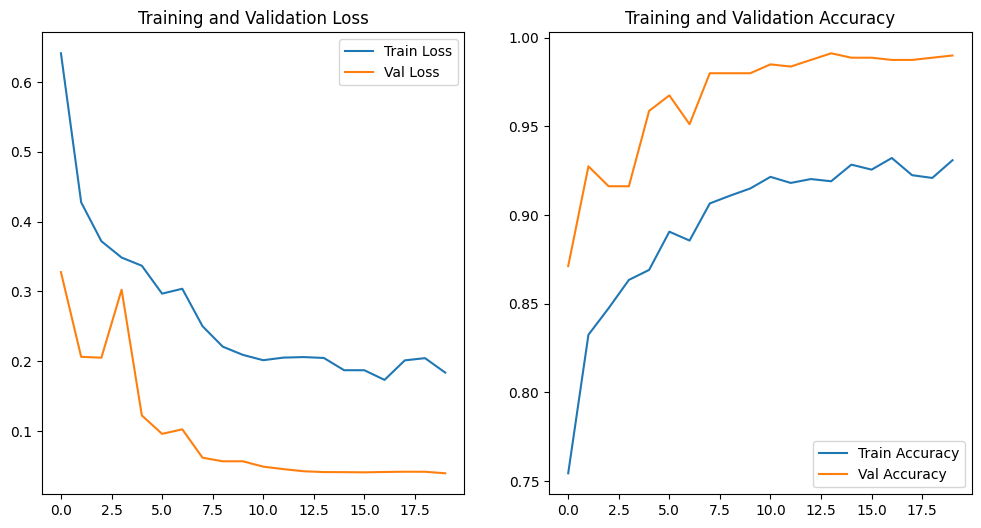

In [10]:
# If AlexNet is selected, initialize the model with pre-trained weights
if model_select == "AlexNet":
    model_ft = models.alexnet(weights=AlexNet_Weights.DEFAULT)
    num_ftrs = model_ft.classifier[6].in_features  # Get the number of features in the last layer
    model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))  # Replace the last layer for the current task

# Move model to the appropriate device (GPU/CPU)
model_ft = model_ft.to(device)

# Define loss weights and convert to tensor
w = np.array([np.sqrt(1632 / (5 * 400)), np.sqrt(1632 / (5 * 400)), np.sqrt(1632 / (5 * 400)), np.sqrt(1632 / (5 * 400)), np.sqrt(1632 / (5 * 32))])
w = torch.from_numpy(w).type(torch.FloatTensor)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent) with learning rate and momentum
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0006, momentum=0.9)

# Define learning rate scheduler with step decay every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', factor=0.1, patience=5, verbose=True)

# Print the device being used
print(device)


# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epochs)



In [11]:
# Define a dummy input tensor with the same size as the model expects
# dummy_input = torch.randn(1, 3, 224, 224)  # Batch size of 1, 3 color channels, 224x224 image size


# Prepare a dummy input tensor
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Ensure dummy_input is on the same device as the model

# Export the model to ONNX format
onnx_path = "alexnet.onnx"
torch.onnx.export(
    model_ft, 
    dummy_input, 
    onnx_path, 
    verbose=True, 
    input_names=['input'], 
    output_names=['output']
)

Exported graph: graph(%input : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cuda:0),
      %features.0.weight : Float(64, 3, 11, 11, strides=[363, 121, 11, 1], requires_grad=1, device=cuda:0),
      %features.0.bias : Float(64, strides=[1], requires_grad=1, device=cuda:0),
      %features.3.weight : Float(192, 64, 5, 5, strides=[1600, 25, 5, 1], requires_grad=1, device=cuda:0),
      %features.3.bias : Float(192, strides=[1], requires_grad=1, device=cuda:0),
      %features.6.weight : Float(384, 192, 3, 3, strides=[1728, 9, 3, 1], requires_grad=1, device=cuda:0),
      %features.6.bias : Float(384, strides=[1], requires_grad=1, device=cuda:0),
      %features.8.weight : Float(256, 384, 3, 3, strides=[3456, 9, 3, 1], requires_grad=1, device=cuda:0),
      %features.8.bias : Float(256, strides=[1], requires_grad=1, device=cuda:0),
      %features.10.weight : Float(256, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cuda:0),
      %features.1

In [12]:
# Visualize the model predictions with actual labels
def visualize_model(model, num_images=6):
    model.eval()  # Set model to evaluation mode
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\nactual: {class_names[labels[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                ax.imshow(np.clip(img, 0, 1))

                if images_so_far == num_images:
                    return

In [13]:
# Create a list for epoch numbers
y = [i + 1 for i in range(epochs)]

In [14]:
# Visualize model predictions
visualize_model(model_ft)

In [15]:
# Evaluate the model using classification metrics
def evaluate_model(model):
    model.eval()  # Set model to evaluation mode

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Convert lists to NumPy arrays for metrics calculation
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Calculate other metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')


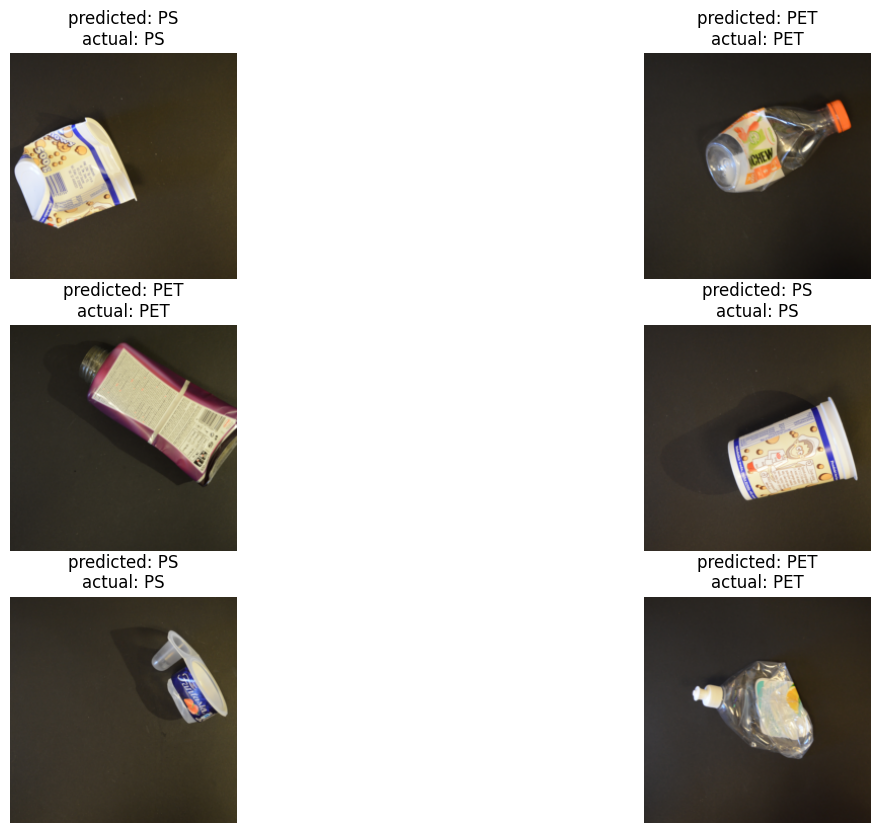

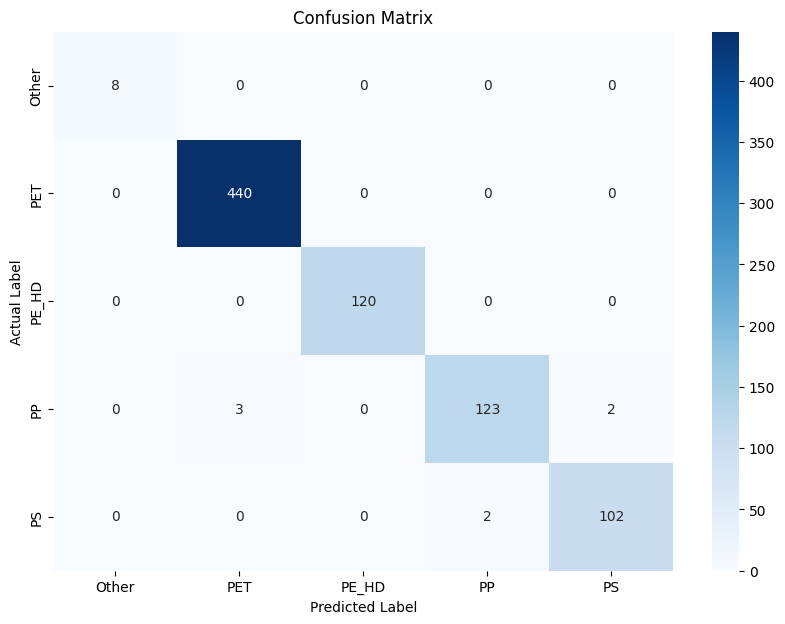

Classification Report:
              precision    recall  f1-score   support

       Other       1.00      1.00      1.00         8
         PET       0.99      1.00      1.00       440
       PE_HD       1.00      1.00      1.00       120
          PP       0.98      0.96      0.97       128
          PS       0.98      0.98      0.98       104

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

Accuracy: 0.9912
Precision: 0.9912
Recall: 0.9912
F1-Score: 0.9912


In [16]:
# Evaluate model performance
evaluate_model(model_ft)